# A. Transform the ACS Data

In [12]:
import pandas as pd

file_path_1 = "acs2017_census_tract_data.csv.gz"
file_path_2 = "COVID_county_data.csv.gz"

df_census= pd.read_csv(file_path_1, compression='gzip')
df_covid= pd.read_csv(file_path_2, compression='gzip',)

print(df_covid.columns)


Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


In [13]:
# concate county and state
df_census['County'] = df_census['County'].replace(' County','', regex=True)
df_census['County_ID'] =  df_census['County'] + ',' + df_census['State']

In [14]:
# Filter only the needed columns
needed_columns = ['County_ID', 'TotalPop', 'IncomePerCap', 'Poverty']
df_census_filtered = df_census[needed_columns]

# Aggregate the data at County level
county_info = df_census_filtered.groupby('County_ID').agg({
    'TotalPop': 'sum',  
    'IncomePerCap': 'mean',   
    'Poverty': 'mean',   
}).reset_index()

In [18]:
county_info['ID'] = range(1, len(county_info) + 1)
# Rename the columns
county_info.columns = [ 'County', 'Population', 'PerCapitaIncome', 'Poverty', 'ID']

In [20]:
county_info.head()

,County,Population,PerCapitaIncome,Poverty,ID
0,"Abbeville,South Carolina",24788,19402.833333,22.183333,1
1,"Acadia Parish,Louisiana",62607,21454.250000,21.933333,2
2,"Accomack,Virginia",32840,24769.750000,20.112500,3
3,"Ada,Idaho",435117,32672.661017,12.608475,4
4,"Adair,Iowa",7192,28840.666667,9.566667,5


In [21]:
# Get the county data for specific counties
selected_counties = ['Loudoun,Virginia', 
                     'Washington,Oregon', 
                     'Harlan,Kentucky', 
                     'Malheur,Oregon']

In [22]:
county_data = county_info[county_info['County'].isin(selected_counties)]

print(county_data)


                 County  Population  PerCapitaIncome    Poverty    ID
1234    Harlan,Kentucky       27548     16010.363636  33.318182  1235
1759   Loudoun,Virginia      374558     50391.015625   3.884375  1760
1822     Malheur,Oregon       30421     17966.428571  24.414286  1823
3047  Washington,Oregon      572071     34970.817308  10.446154  3048


In [23]:
# Most populous county
most_populous_county = county_info[county_info['Population'] == county_info['Population'].max()]['County'].values[0]

# # Least populous county
least_populous_county = county_info[county_info['Population'] == county_info['Population'].min()]['County'].values[0]

print(f'Most populous county in the USA: {most_populous_county}')
print(f'Least populous county in the USA: {least_populous_county}')

Most populous county in the USA: Los Angeles,California
Least populous county in the USA: Loving,Texas


# B. Transform the COVID Data

In [25]:
df_covid= pd.read_csv(file_path_2, compression='gzip',)
df_covid['date'] = pd.to_datetime(df_covid['date'])

In [26]:
# Add a county ID column that is a foreign key lookup to the corresponding ID column in the County_info DataFrame
df_covid['county'] = df_covid['county'].replace(' County','', regex=True)
df_covid['County_ID'] =  df_covid['county'] + ',' + df_covid['state']

In [27]:
# Create a 'month' column
df_covid['month'] = df_covid['date'].dt.to_period('M')


In [28]:
# Group by 'County_ID' and 'month', then calculate the sum of 'cases' and 'deaths'
df_covid_monthly = df_covid.groupby(['County_ID', 'month']).agg({
    'cases': 'sum',
    'deaths': 'sum',
}).reset_index()

In [29]:
df_covid_monthly['ID'] = range(1, len(df_covid_monthly) + 1)

In [30]:
# Rename the columns
df_covid_monthly.columns = ['County', 'Month', 'cases', 'deaths', 'ID']

In [32]:
df_covid_monthly.head()

,County,Month,cases,deaths,ID
0,"Abbeville,South Carolina",2020-03,32,0.0,1
1,"Abbeville,South Carolina",2020-04,430,0.0,2
2,"Abbeville,South Carolina",2020-05,1080,0.0,3
3,"Abbeville,South Carolina",2020-06,2187,0.0,4
4,"Abbeville,South Carolina",2020-07,5959,65.0,5


In [34]:
# Get the covid data for specific months for Malheur County, Oregon
selected_months = ['2020-08', '2021-01', '2021-02']
selected_county = 'Malheur,Oregon'

In [38]:
check= df_covid_monthly[df_covid_monthly['County'] == 'Malheur,Oregon']
check

,County,Month,cases,deaths,ID
20777,"Malheur,Oregon",2020-03,1,0.0,20778
20778,"Malheur,Oregon",2020-04,125,0.0,20779
20779,"Malheur,Oregon",2020-05,626,0.0,20780
20780,"Malheur,Oregon",2020-06,1447,24.0,20781
20781,"Malheur,Oregon",2020-07,12773,130.0,20782
20782,"Malheur,Oregon",2020-08,28163,459.0,20783
20783,"Malheur,Oregon",2020-09,43150,693.0,20784
20784,"Malheur,Oregon",2020-10,56398,1061.0,20785
20785,"Malheur,Oregon",2020-11,65787,1174.0,20786
20786,"Malheur,Oregon",2020-12,82916,1465.0,20787


In [39]:
covid_data = df_covid_monthly[(df_covid_monthly['County'] == selected_county) & 
                              (df_covid_monthly['Month'].astype(str).isin(selected_months))]

print(covid_data)

               County    Month  cases  deaths     ID
20782  Malheur,Oregon  2020-08  28163   459.0  20783
20787  Malheur,Oregon  2021-01  96297  1627.0  20788
20788  Malheur,Oregon  2021-02  65951  1137.0  20789


# Integrate COVID Data with ACS Data

In [40]:
# Merge the county_info and df_covid_monthly DataFrames on 'County'
covid_summary = pd.merge(county_info, df_covid_monthly, on='County' )

In [41]:
# Sum 'cases' and 'deaths' over all months
covid_summary_totals = covid_summary.groupby('County').agg({
    'cases': 'sum',
    'deaths': 'sum',
}).reset_index()

In [42]:
# Merge the covid_summary_totals into covid_summary
covid_summary = pd.merge(covid_summary, covid_summary_totals, on='County', suffixes=('', '_total'))

In [43]:
# Calculate TotalCasesPer100K and TotalDeathsPer100K
covid_summary['TotalCasesPer100K'] = covid_summary['cases_total'] / (covid_summary['Population'] / 100000)
covid_summary['TotalDeathsPer100K'] = covid_summary['deaths_total'] / (covid_summary['Population'] / 100000)

In [44]:
# Filter only needed columns
covid_summary = covid_summary[['County', 'Population', 'Poverty', 'PerCapitaIncome', 'cases_total', 'deaths_total', 'TotalCasesPer100K', 'TotalDeathsPer100K']]

In [45]:
# Rename the columns
covid_summary.columns = ['County', 'Population', 'Poverty', 'PerCapitaIncome', 'TotalCases', 'TotalDeaths', 'TotalCasesPer100K', 'TotalDeathsPer100K']

In [46]:
# Get the covid summary data for specific counties
selected_counties = ['Washington,Oregon', 'Malheur,Oregon', 'Loudoun,Virginia', 'Harlan,Kentucky']

covid_summary_data = covid_summary[covid_summary['County'].isin(selected_counties)]

print(covid_summary_data.drop_duplicates(subset='County'))

                  County  Population    Poverty  PerCapitaIncome  TotalCases  \
13469    Harlan,Kentucky       27548  33.318182     16010.363636      205984   
19192   Loudoun,Virginia      374558   3.884375     50391.015625     2496450   
19880     Malheur,Oregon       30421  24.414286     17966.428571      453634   
33307  Washington,Oregon      572071  10.446154     34970.817308     2157339   

       TotalDeaths  TotalCasesPer100K  TotalDeathsPer100K  
13469       3994.0       7.477276e+05        14498.330187  
19192      35820.0       6.665056e+05         9563.271910  
19880       7770.0       1.491187e+06        25541.566681  
33307      22455.0       3.771104e+05         3925.212080  


# D. Analysis

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter Oregon counties
covid_summary_oregon = covid_summary[covid_summary['County'].str.contains('Oregon')]

In [48]:
# Compute correlations for Oregon
R_cases_poverty_oregon = covid_summary_oregon['TotalCasesPer100K'].corr(covid_summary_oregon['Poverty'])
R_deaths_poverty_oregon = covid_summary_oregon['TotalDeathsPer100K'].corr(covid_summary_oregon['Poverty'])
R_cases_income_oregon = covid_summary_oregon['TotalCasesPer100K'].corr(covid_summary_oregon['PerCapitaIncome'])
R_deaths_income_oregon = covid_summary_oregon['TotalDeathsPer100K'].corr(covid_summary_oregon['PerCapitaIncome'])

In [49]:
# Compute correlations for the entire USA
R_cases_poverty_usa = covid_summary['TotalCasesPer100K'].corr(covid_summary['Poverty'])
R_deaths_poverty_usa = covid_summary['TotalDeathsPer100K'].corr(covid_summary['Poverty'])
R_cases_income_usa = covid_summary['TotalCasesPer100K'].corr(covid_summary['PerCapitaIncome'])
R_deaths_income_usa = covid_summary['TotalDeathsPer100K'].corr(covid_summary['PerCapitaIncome'])

In [50]:
# Fill your table (just a print statement here)
print(f"For Oregon Counties only: correlation between % poverty and COVID cases: {R_cases_poverty_oregon}")
print(f"For all counties: correlation between population and COVID cases: {R_cases_poverty_usa}")
print(f"For Oregon counties only: correlation between PerCapitaIncome and COVID deaths: {R_deaths_income_oregon}")
print(f"For all USA counties: correlation between PerCapitaIncome and COVID cases: {R_cases_income_usa}")

For Oregon Counties only: correlation between % poverty and COVID cases: 0.2447299686786285
For all counties: correlation between population and COVID cases: 0.18944140940205254
For Oregon counties only: correlation between PerCapitaIncome and COVID deaths: -0.3745502321691788
For all USA counties: correlation between PerCapitaIncome and COVID cases: -0.20859423601453833


In [51]:
# Additional correlation computation 
# (example: correlation between PerCapitaIncome and Poverty for all USA counties)
R_income_poverty_usa = covid_summary['PerCapitaIncome'].corr(covid_summary['Poverty'])
print(f"For all USA counties: correlation between PerCapitaIncome and Poverty: {R_income_poverty_usa}")

For all USA counties: correlation between PerCapitaIncome and Poverty: -0.7032400691324645


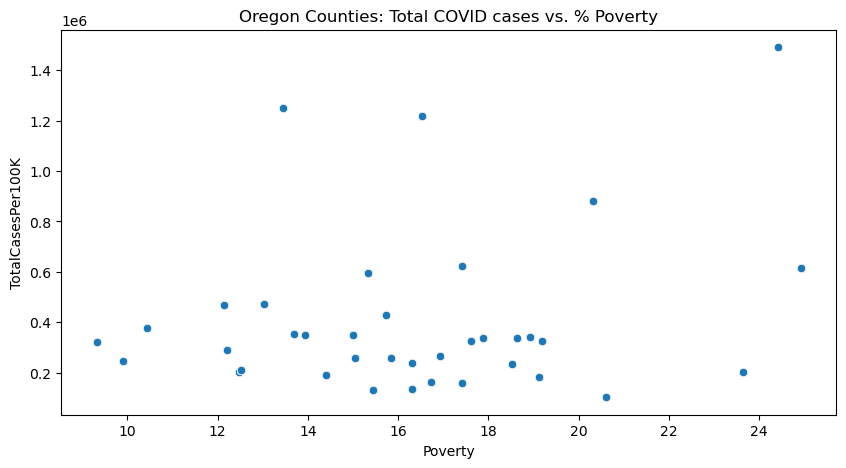

In [59]:
# Generate scatter plot if |R| > 0.5
if abs(R_cases_poverty_oregon) > 0.2:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='Poverty', y='TotalCasesPer100K', data=covid_summary_oregon)
    plt.title("Oregon Counties: Total COVID cases vs. % Poverty")
    plt.show()